In [21]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Coloring-greyscale-images-master/Full-version

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Coloring-greyscale-images-master/Full-version


In [22]:
import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Layer
from tensorflow.keras.applications.inception_v3 import preprocess_input

from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate,  Dense
from keras.layers import Activation, Dense, Dropout, Flatten
import tensorflow as tf
tf.keras.layers.BatchNormalization()
from keras.callbacks import TensorBoard 
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers.core import RepeatVector, Permute

from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

In [23]:
from PIL import Image


# Get images
X = []
for filename in os.listdir('Train/'):
    img = load_img('Train/' + filename)
    img = img_to_array(img)
    img = resize(img, (256, 256), mode='constant')
    X.append(img)
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X
   # X.append(img_to_array(load_img('simple_images/'+filename)))



#Load weights
inception = InceptionV3(weights='imagenet', include_top=True)
# create a TensorFlow session
sess = tf.compat.v1.keras.backend.get_session()

In [24]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [25]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with sess.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


#Train model      
model.compile(optimizer='rmsprop', loss='mse')
model.fit(image_a_b_gen(batch_size), epochs=1, steps_per_epoch=1)

1/1 [==============================] - 22s 22s/step - loss: 0.0270


In [26]:
color_me = []
image_size = (256, 256)  # Specify the desired image size

for filename in os.listdir('Test/'):
    image = load_img('Test/' + filename, target_size=image_size)
    color_me.append(img_to_array(image))

color_me = np.array(color_me, dtype=float)

gray_me = gray2rgb(rgb2gray(1.0/255 * color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0/255 * color_me)[:, :, :, 0]
color_me = color_me.reshape(color_me.shape + (1,))

# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = color_me[i][:, :, 0]
    cur[:, :, 1:] = output[i]
    cur = np.clip(cur, 0, 255).astype(np.uint8)  # Clip values to [0, 255] range
    cur_rgb = lab2rgb(cur.astype(np.float64))
    cur_rgb = np.clip(cur_rgb, 0, 1)  # Clip values to [0, 1] range
    cur_rgb = (cur_rgb * 255).astype(np.uint8)  # Convert to uint8
    Image.fromarray(cur_rgb).save("result/imgdata_" + str(i) + ".png", format='png')

1/1 [==============================] - 6s 6s/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 292 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 58 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 291 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 144 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 181 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_

  0%|          | 0/16 [00:00<?, ?it/s]

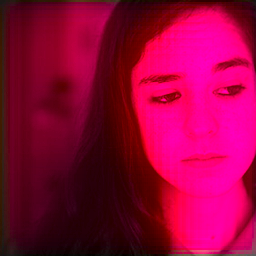

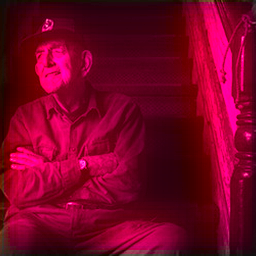

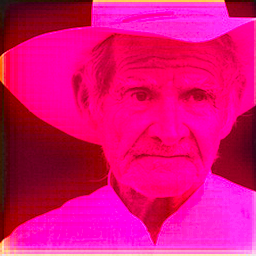

 19%|█▉        | 3/16 [00:00<00:00, 23.06it/s]

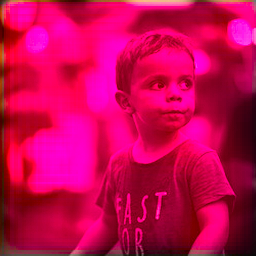

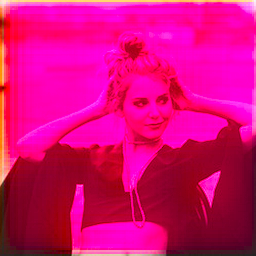

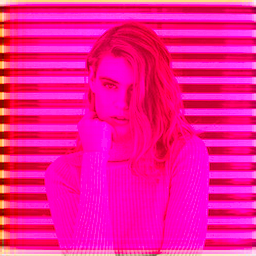

 38%|███▊      | 6/16 [00:00<00:00, 21.34it/s]

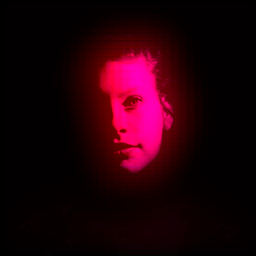

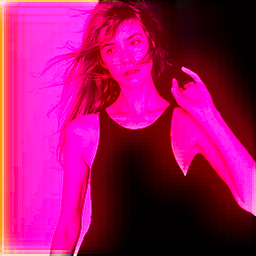

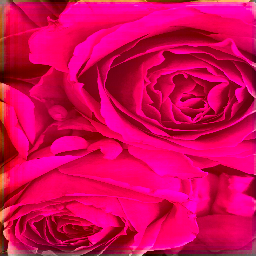

 56%|█████▋    | 9/16 [00:00<00:00, 22.78it/s]

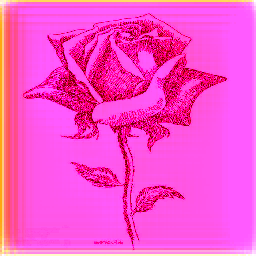

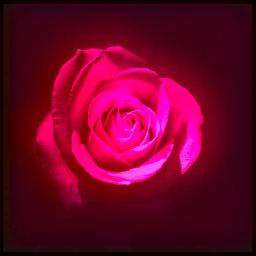

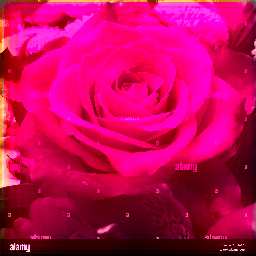

 75%|███████▌  | 12/16 [00:00<00:00, 22.84it/s]

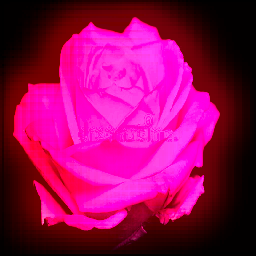

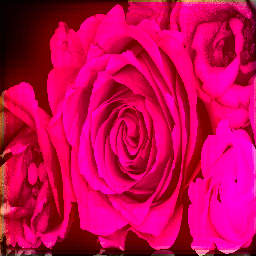

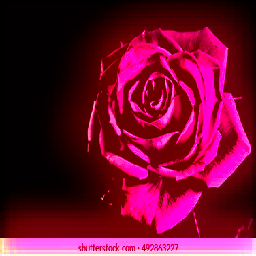

 94%|█████████▍| 15/16 [00:00<00:00, 23.12it/s]

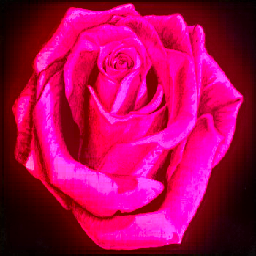

100%|██████████| 16/16 [00:00<00:00, 22.11it/s]


In [27]:
import cv2
import os
from tqdm import tqdm
from google.colab.patches import cv2_imshow

BASE_DIR = '/content/gdrive/MyDrive/Coloring-greyscale-images-master/Full-version/result'

# Iterate over the files in the directory and display each image
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    # Display the image using OpenCV
    cv2_imshow( image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()